<a href="https://colab.research.google.com/github/marcomorigi95/Cross-selling/blob/main/Morigi_Marco_CrossSelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective

Our client is an Indian insurance company (for deatails: https://www.kaggle.com/datasets/anmolkumar/health-insurance-cross-sell-prediction/data) that has provided Health Insurance to its customers. Now they need a way to predict better and not by chance whether the policyholders (customers) from past years will also be interested in vehicle insurance provided by the company.

In order to predict whether the customer would be interested in vehicle insurance, we have information about Demographics (gender, age, region code type), Vehicles (Vehicle Age, Damage), Policy (Premium, sourcing channel) etc.

Given that it is an Indian insurance company, when we will make our considerations we must take into account that the currency and demographic distribution will be those of India.

# Libriries

In [ ]:
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Exploratory data analysis
from scipy.stats import ks_2samp
from dython import nominal
from collections import Counter
from scipy.stats import uniform

# Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

# Metrics
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

# resampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTENC

# model interpretation
import lime
import lime.lime_tabular

import warnings
warnings.filterwarnings('ignore')

# Custom Functions

In [ ]:
def mapping(df, list):
    """
    Convert the "1" and "0" in "Yes" and "No".

    Parameters
    ----------
    df: dataframe
    list: list of desired column
    """
    mapping = {1: "Yes", 0: "No"}
    for i in list:
        df[i] = df[i].map(mapping)




def plot_numerical(df, col):
    """
    Plot numeric variables only and plots two graphs:
     - The first is a histogram of the column of interest and the skewness is also contained in the title.
     - In the second graph there is a boxplot of the column of interest divided by the modalities of the Response variable.

    Parameters
    ----------
    df: dataframe
    col: desired column

    """

    plt.figure(figsize=(13, 5))

    # histogram
    plt.subplot(1, 2, 1)
    plt.title(f"{col} | Skewness: {round(df[col].skew(), 2)}")
    df[col].hist(grid=False, edgecolor="white", linewidth=0.7)
    plt.ylabel("Count")
    plt.xlabel(col)

    # boxplot
    plt.subplot(1, 2, 2)
    plt.title(f"{col} by Response")
    sns.boxplot(data=df, y=col, x="Response", hue="Response", gap=.1)
    plt.ylabel(col)
    plt.xlabel("Response")




def plot_categorical(df, col):
    """
    Plot categorical variables only and plots two graphs:
     - The first is a histogram of the column count of interest.
     - In the second graph there is a histogram of the column of interest divided by the modalities of the Response variable.

    Parameters
    ----------
    df: dataframe
    col: desired column
    """

    plt.figure(figsize=(14, 4))

    # histogram
    plt.subplot(1, 2, 1)
    plt.title(f"Count {col}")
    sns.countplot(data=df, x=df[col], order=df[col].value_counts().iloc[:10].index)
    plt.xticks(rotation="horizontal")
    plt.ylabel("count")

    # histogram by Response
    plt.subplot(1, 2, 2)
    plt.title(f"{col} by Response")
    sns.countplot(data=df, x=df[col], hue="Response", order=df[col].value_counts().iloc[:10].index)
    plt.ylabel("count")
    plt.xticks(rotation="horizontal")



def cross_tabulation(df, y, x):
    """
    Adds percentage values in addition to absolute values to the output of the pandas crosstab function.
    For details: https://pandas.pydata.org/docs/reference/api/pandas.crosstab.html


    Parameters
    ----------
    df: dataframe
    y: response variable
    x: desired column
    """

    print(f"Frequency table of {x} by {y}\n")

    # will normalize over each column
    tab1 = pd.crosstab(columns=df[x], index=df[y], normalize="columns")

    # calculate and print the percentage values inside the parentheses
    tab1 = ("(" + (tab1*100).round(1).astype(str) + "%)")

    tab2 = pd.crosstab(columns=df[x], index=df[y])

    # add "%" to the new percentage columns
    for i in (df[x].unique()):
        tab1 = tab1.rename(columns={i: f"{i}(%)"})

    # merge the two tables
    tab = pd.concat([tab2, tab1], axis=1, join="inner").sort_index(axis=1, ascending=True)
    print(tab)




def aggregate_less_frequent(df, col, threshold):
    """
    Aggregates under the name "Other" all the modealities of a column that occur with low
    frequency below a chosen threshold.

    Parameters
    ----------
    df: dataframe
    col: desired column
    threshold: minimum frequency threshold
    """

    x = df[col].copy()
    x[x.replace(x.value_counts().to_dict()) < len(x)*threshold] = "Other"

    return x

# Dataset first exploration

In [ ]:
url = "https://proai-datasets.s3.eu-west-3.amazonaws.com/insurance_cross_sell.csv"
df = pd.read_csv(url, encoding="utf-8")

In [ ]:
df.head(3)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1


Since we have some of the binary categories coded in binary and some not, in order to make the graphs and the various parts of descriptive analysis more intuitive and immediate to understand, for now we are going to convert all the binary variables into "Yes" and "No" as follows:   


In [ ]:
column_list = ["Driving_License", "Previously_Insured", "Response"]

# Convert 1 and 0 in "Yes" and "No"
mapping(df, column_list)


# Since they are categorical variables, we convert them to string
df["Region_Code"] = df["Region_Code"].map(str)
df["Policy_Sales_Channel"] = df["Policy_Sales_Channel"].map(str)

Now, let's see how the dataframe looks:

In [ ]:
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,Yes,28.0,No,> 2 Years,Yes,40454.0,26.0,217,Yes
1,2,Male,76,Yes,3.0,No,1-2 Year,No,33536.0,26.0,183,No
2,3,Male,47,Yes,28.0,No,> 2 Years,Yes,38294.0,26.0,27,Yes
3,4,Male,21,Yes,11.0,Yes,< 1 Year,No,28619.0,152.0,203,No
4,5,Female,29,Yes,41.0,Yes,< 1 Year,No,27496.0,152.0,39,No


The variable **id** does not give us any information, hence we remove it.

In [ ]:
df = df.drop("id", axis=1)

Let's check some information about a dataframe data type, columns, non-null values and memory usage.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  object 
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  object 
 3   Region_Code           381109 non-null  object 
 4   Previously_Insured    381109 non-null  object 
 5   Vehicle_Age           381109 non-null  object 
 6   Vehicle_Damage        381109 non-null  object 
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  object 
 9   Vintage               381109 non-null  int64  
 10  Response              381109 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 32.0+ MB


As we can see, we have 381109 customers and the variables available are:

**Age**: Continuous quantitative on a ratio scale    
**Driving_License**: Dichotomous (Nominal)   
**Region_Code**: Nominal qualitative      
**Previously_Insured**: Dichotomous (Nominal)   
**Vehicle_Age**: Ordinal qualitative                 
**Vehicle_Damage**: Dichotomous (Nominal)   
**Annual_Premium**:  Continuous quantitative on a ratio scale       
**Policy_Sales_Channel**: Nominal qualitative   
**Vintage**: Continuous quantitative on a ratio scale               
**Response**: Dichotomous (Nominal)

Let's check whether there are null values or duplicate values in the dataframe:

In [ ]:
df.isnull().sum()

Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

There are no null values.

In [ ]:
print(Counter(df.duplicated()))

Counter({False: 380840, True: 269})


There appear to be only 269 duplicates, but is it true? Or are there any more?\
It might be that the same record has been entered twice by mistake: once it has been inserted for the first time, it is inserted again without deleting the previously inserted record. This can be noted because in these data entries, only a single field is different. If 10 out 11 fields are the same, there is a strong possibility of having potential duplicates.   
Now, to discover if there are more of those, we will drop one column at once and check for any possible duplicates.


In [ ]:
for i in df.columns:
    col_to_remove = i
    col_removed = df[col_to_remove]

    df = df.drop(columns=[col_to_remove])

    df = df.drop_duplicates()

    # re-add the removed column
    df[col_to_remove] = col_removed

In [ ]:
print(f"Current number of customers without any potential duplicates: {df.shape[0]}")

Current number of customers without any potential duplicates: 311932


As we can see, by dropping one by one the columns we find more potential duplicates and since 10 out 11 fields are the same they are likely to be error/duplicates entries. Now all duplicates are correctly removed.

# Exploratory Data Analysis (EDA) and Preprocessing

Let's create two subdataframes containing the categorical and numeric columns. This will make it easier for us to calculate and display the EDA.

In [ ]:
df_num =  df[["Age", "Annual_Premium", "Vintage"]]
df_cat = df.drop(columns=(df_num))

## Numerical Variables

Let's start with a bit of descriptive analysis to get a first idea of what the available variables are like.

In [ ]:
df_num.describe(include="all").T.round(1)

,count,mean,std,min,25%,50%,75%,max
Age,311932.0,39.9,15.8,20.0,25.0,38.0,51.0,85.0
Annual_Premium,311932.0,32315.3,16058.8,2630.0,26109.0,32415.0,39914.0,540165.0
Vintage,311932.0,154.2,83.7,10.0,82.0,154.0,227.0,299.0


As for the variable **Age**, at first glance it seems that the majority of customers are young with a median of 38 years, maybe due to the distribution of the Indian population.

For more details:  
https://www.statista.com/statistics/271315/age-distribution-in-india/



As for the variable **Annual_Premium**, we note that the minimum value is 2630₹ (INR) and the maximum is 540,165₹ (INR), a notable difference considering that at the annual national level we have an average car insurance cost of 20,000₹ + health insurance cost of 30,000₹ for a total of 50,000₹. Let's also consider that the average salary is 965,350₹ per year. On this topic, more consideration will be made later.

For more details:  
https://www.forbes.com/advisor/in/business/average-salary-by-age/

https://www.adityabirlacapital.com/healthinsurance/health-insurance-guide/what-is-the-cost-of-health-insurance-in-india

https://www.forbes.com/advisor/in/car-insurance/average-cost-of-car-insurance/



As for the variable **Vintage**, it just shows us the number of days since the customer has been a client of the company.

Let's observe graphically how the numerical variables appear through histplot, box plot by response and the relative skewness.

### Age

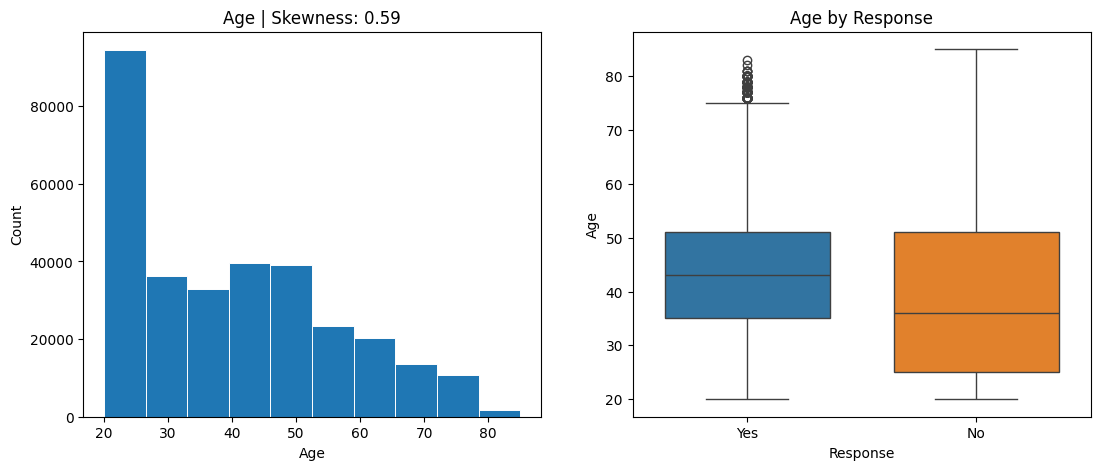

In [ ]:
plot_numerical(df, "Age")

The **Age** variable is right skewed due to the fact that the majority of customers are in their 20s.

From the boxplot we notice that older customers tend to be more inclined to accept a car insurance, while younger ones are more likely to refuse the offer. This could also be due to the fact that they have less economic availability or don't have their own car. We note the presence of some outliers but since they fall within the plausible age range, these are not suspicious values.

### Annual_Premium

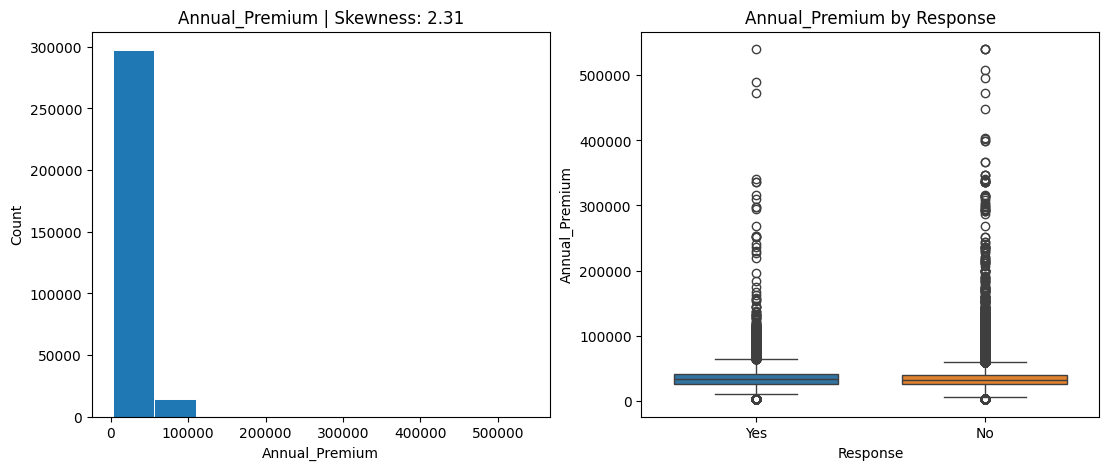

In [ ]:
plot_numerical(df, "Annual_Premium")

**Annual_Premium** has a strong positive skewness and we notice the presence of many outliers due to very high values, which may suggest that there are incorrect data entries (we do not have a domain expert available to consult).

Let's investigate in a little more detail, setting a threshold of 80,000₹ (chosen by me as a plausible value for the cost of an annual insurance in India after looking at the sources provided previously, also considering those who may have multiple vehicles).

In [ ]:
print(Counter(df["Annual_Premium"] < 80000))

Counter({True: 309961, False: 1971})


So we have 1971 "suspicious" values. Since there are a few outliers we opt to change their values with a median value.

In [ ]:
median_val = df["Annual_Premium"][df["Annual_Premium"] < 80000].median()

df["Annual_Premium"] = np.where(df["Annual_Premium"] >= 80000, median_val, df["Annual_Premium"])

Let's observe how the histogram and skewness change:

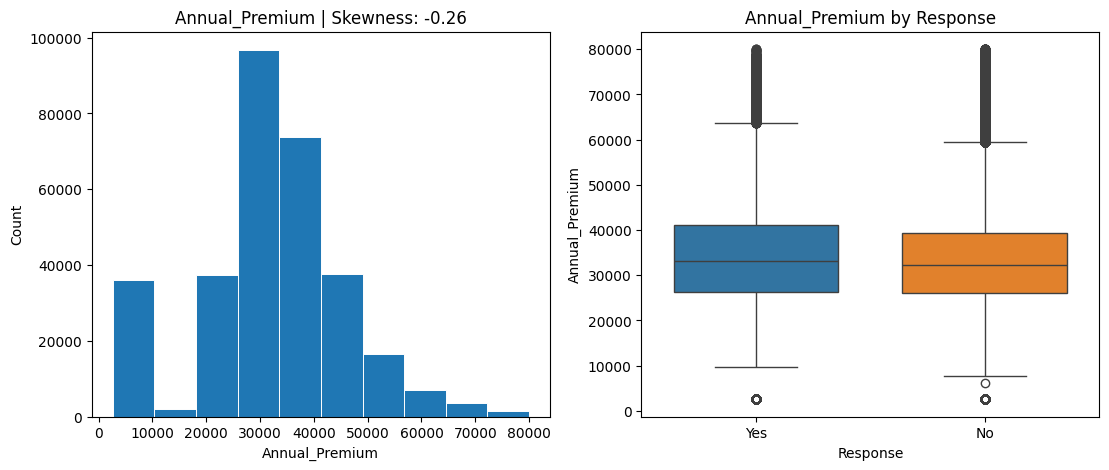

In [ ]:
plot_numerical(df, "Annual_Premium")

Now it is clearer how the **Annual_Premium** variable is distributed (now it is more in line with the data reported by the sources).
We notice an improvement in skewness, but also almost no values between 10,000₹ and 20,000₹. What is this gap due to?

I think (again, without excluding some possible transcription errors) it could be due to the fact that the basic plan is around 3000₹ while plans with more benefits start from 20,000₹. Still, in the absence of a domain expert, I won't make any further hypotheses.

### Vintage

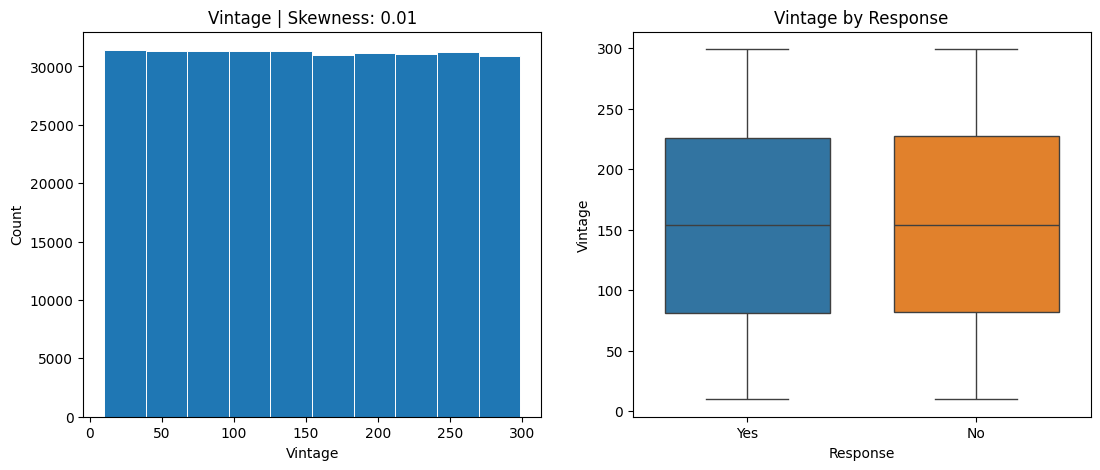

In [ ]:
plot_numerical(df, "Vintage")

It seems to be symmetrical and no differences can be seen between customers who responded positively or negatively.

### Control by hypothesis testing

We use the Kolmogorov-Smirnov test to establish the significance of the difference between the distributions.

**Null hypothesis**: the two distributions are equal. We reject the null hypothesis if the p-value of the test is less than 5%.

In [ ]:
for col in df_num:
    response_no = df[df["Response"] == "No"][col]
    response_yes = df[df["Response"] == "Yes"][col]
    print(f"{col} by Response P-value:", ks_2samp(response_no, response_yes)[1])

Age by Response P-value: 0.0
Annual_Premium by Response P-value: 2.4393069654788827e-85
Vintage by Response P-value: 0.5488703274612755


As excepted from previous graphs and the double check from testing the hypothesis, for **Age** and **Annual_Premium** there are significant differences. As for **Vintage**, the are no significant differences between distributions, thus we might consider removing this variable, if necessary.

## Categorical Variables

In [ ]:
df_cat.describe().T

,count,unique,top,freq
Gender,311932,2,Male,170632
Driving_License,311932,2,Yes,311124
Region_Code,311932,53,28.0,85478
Previously_Insured,311932,2,No,177834
Vehicle_Age,311932,3,1-2 Year,172467
Vehicle_Damage,311932,2,Yes,165265
Policy_Sales_Channel,311932,155,152.0,98913
Response,311932,2,No,269472


The table shows us the number of unique clasess and top frequent class for every categoriacal variabile. Let's look in details at the various distributions of the categorical variables.

**Note**: for readability of the **Region_Code** and **Policy_Sales_Channel** variables, only the first 10 classes are shown in decreasing order.


### Gender

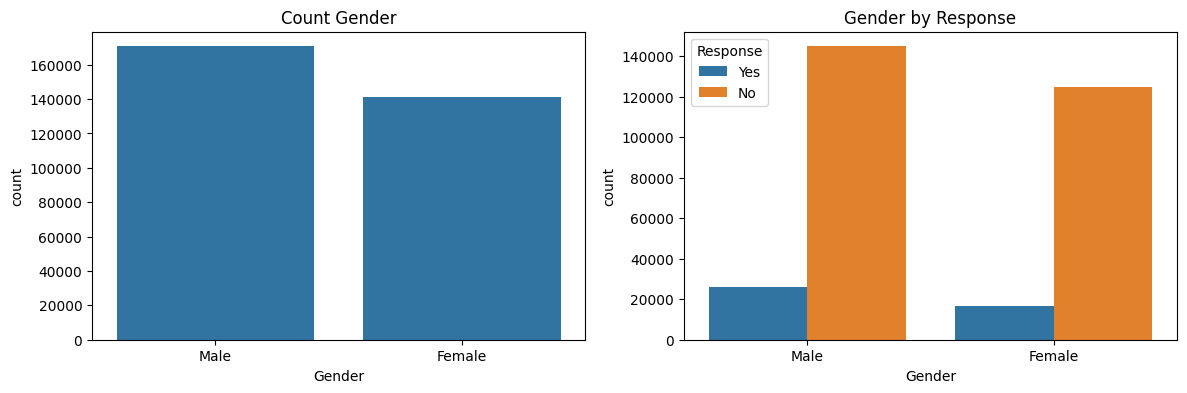

In [ ]:
plot_categorical(df, "Gender")

In [ ]:
cross_tabulation(df, "Response", "Gender")

Frequency table of Gender by Response

Gender    Female Female(%)    Male  Male(%)
Response                                   
No        124650   (88.2%)  144822  (84.9%)
Yes        16650   (11.8%)   25810  (15.1%)


As can be seen from the graphs, the male gender is present in greater frequency than the female one.  
From the frequency table we can see that in males there is a slightly greater tendency to accept car insurance (15.1%) compared to females (11.8%)

### Driving License

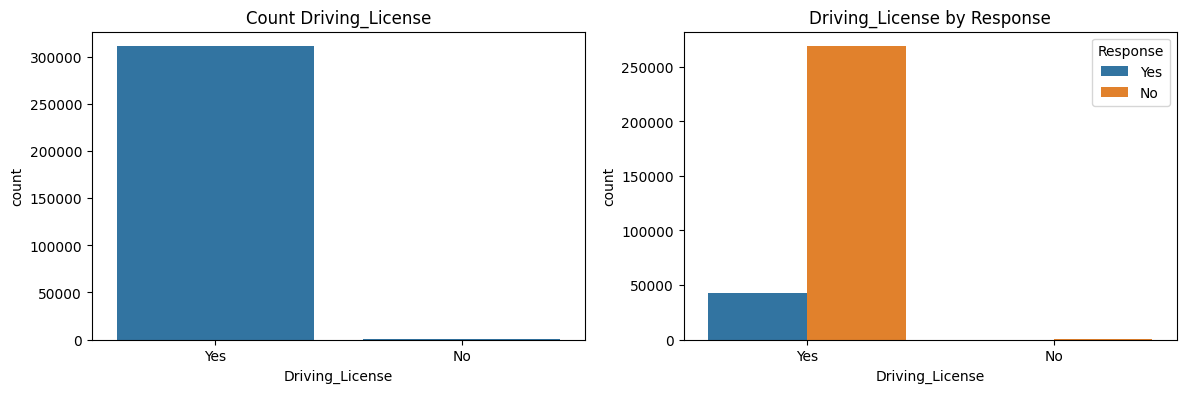

In [ ]:
plot_categorical(df, "Driving_License")

In [ ]:
cross_tabulation(df, "Response", "Driving_License")

Frequency table of Driving_License by Response

Driving_License   No    No(%)     Yes   Yes(%)
Response                                      
No               767  (94.9%)  268705  (86.4%)
Yes               41   (5.1%)   42419  (13.6%)


Intuitively, customers with a driving license are those interested in having car insurance, but there are 41 people who do not have a driving license and have taken out vehicle insurance. Why? Are these errors or parents who registered a car then used by their sons?

Two options can be considered:

1) Eliminating the 808 lines of customers who do not have a driving license. That is, systematically do not consider customers who do not have a driving license.

2) Keeping these 808 lines to generalize better. Perhaps the sample collected, even if large in size, does not perfectly capture this characteristic. As we will note below, the data collected are concentrated in certain regions and there may be the possibility that this characteristic is not captured in these regions.

So, to prevent the model from losing its ability to generalize when receiving new data, I opted to leave it for now.

### Region Code

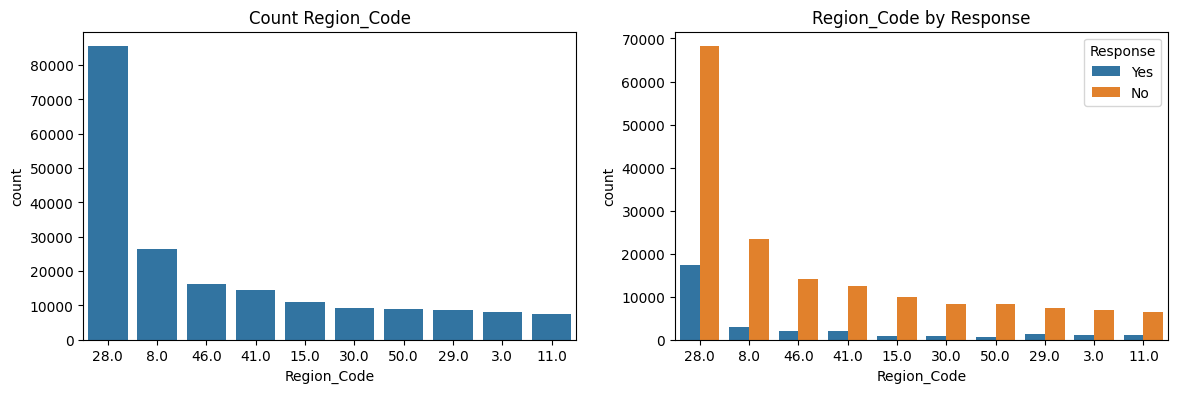

In [ ]:
plot_categorical(df, "Region_Code")

In [ ]:
cross_tabulation(df, "Response", "Region_Code")

Frequency table of Region_Code by Response

Region_Code   0.0   0.0(%)  1.0   1.0(%)  10.0  10.0(%)  11.0  11.0(%)  12.0  \
Response                                                                       
No           1008  (88.9%)  531  (85.8%)  3419  (93.0%)  6327  (86.5%)  2505   
Yes           126  (11.1%)   88  (14.2%)   257   (7.0%)   984  (13.5%)   298   

Region_Code  12.0(%)  ...  52.0  52.0(%)   6.0   6.0(%)   7.0   7.0(%)    8.0  \
Response              ...                                                       
No           (89.4%)  ...   228  (87.4%)  4489  (91.2%)  2339  (85.5%)  23293   
Yes          (10.6%)  ...    33  (12.6%)   435   (8.8%)   397  (14.5%)   3032   

Region_Code   8.0(%)   9.0   9.0(%)  
Response                             
No           (88.5%)  2617  (91.3%)  
Yes          (11.5%)   249   (8.7%)  

[2 rows x 106 columns]


As mentioned before, only the first 10 out of 55 regions by frequency are shown. You can immediately notice that after a couple of regions there is a drastic drop of observations.

We have no information on the scope of action of the insurance company, whether it is at a national level or only in certain areas, and on what the various **Region_code** codes correspond to. For this reason we must be careful, because our dataset may not be representative of the population. Since we could be in the situation of measuring a particular “cluster”, the various data could be influenced by phenomena such as area, public transportaion availability etc. Since we have no information about this, some precautions will be taken when we draw conclusions.


### Previously Insured

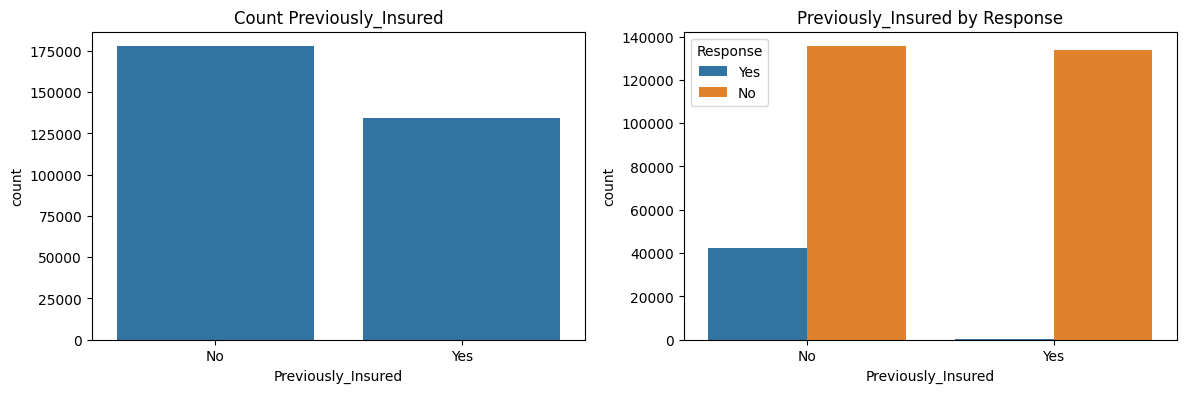

In [ ]:
plot_categorical(df, "Previously_Insured")

In [ ]:
cross_tabulation(df, "Response", "Previously_Insured")

Frequency table of Previously_Insured by Response

Previously_Insured      No    No(%)     Yes   Yes(%)
Response                                            
No                  135532  (76.2%)  133940  (99.9%)
Yes                  42302  (23.8%)     158   (0.1%)


Those who have not yet taken out vehicle insurance tend to be much more inclined to accept the offer while those who have already taken out vehicle insurance only gave a positive response in 0.1% of cases. Is it an error or peraphs are those people with multiple vehicles?

### Vehicle Age

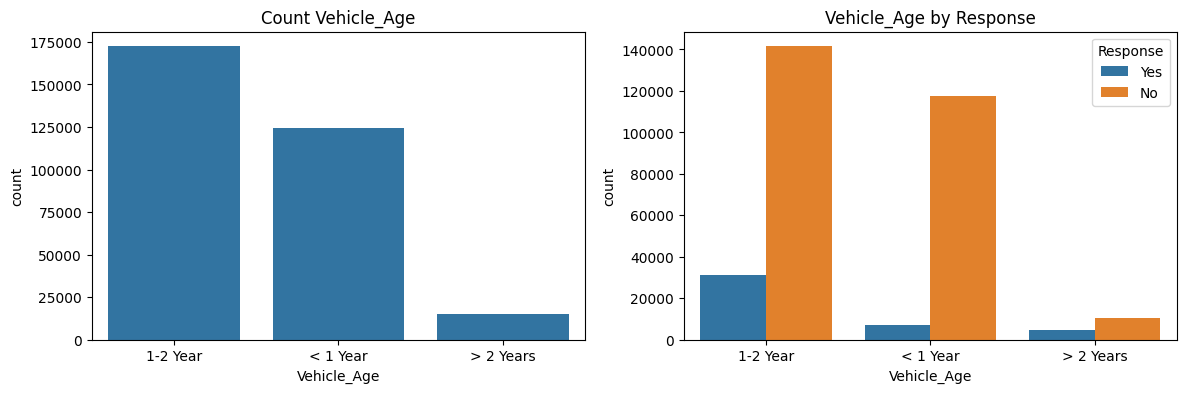

In [ ]:
plot_categorical(df, "Vehicle_Age")

In [ ]:
cross_tabulation(df, "Response", "Vehicle_Age")

Frequency table of Vehicle_Age by Response

Vehicle_Age  1-2 Year 1-2 Year(%)  < 1 Year < 1 Year(%)  > 2 Years  \
Response                                                             
No             141484     (82.0%)    117355     (94.4%)      10633   
Yes             30983     (18.0%)      6961      (5.6%)       4516   

Vehicle_Age > 2 Years(%)  
Response                  
No               (70.2%)  
Yes              (29.8%)  


As we can see from the graphs, in terms of absolute frequencies, customers with a car up to 2 years old are more frequent, also with regards to the absolute number of positive answers.

However, if we consider the percentage frequencies we notice a clear difference where 30% of customers with a car more than 2 years old gave a positive response.

### Vehicle Damage

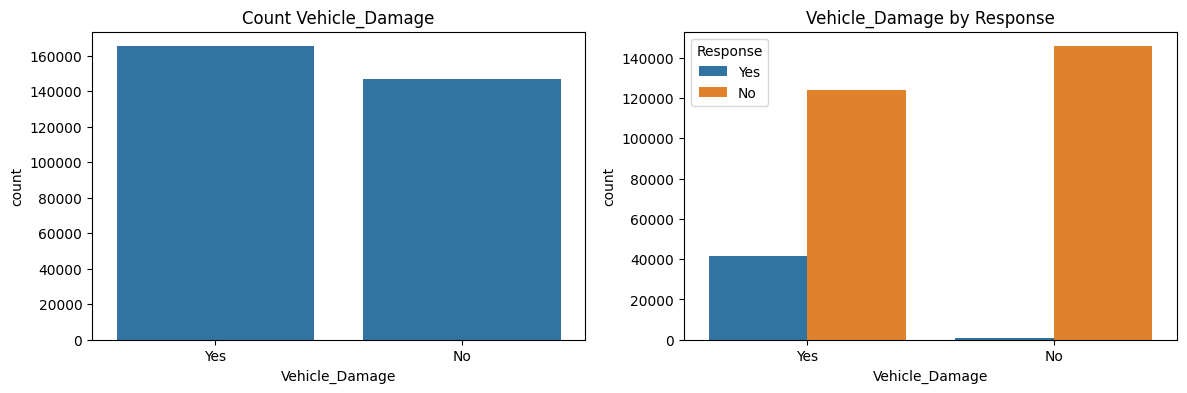

In [ ]:
plot_categorical(df, "Vehicle_Damage")

In [ ]:
cross_tabulation(df, "Response", "Vehicle_Damage")

Frequency table of Vehicle_Damage by Response

Vehicle_Damage      No    No(%)     Yes   Yes(%)
Response                                        
No              145694  (99.3%)  123778  (74.9%)
Yes                973   (0.7%)   41487  (25.1%)


From the graphs we can see how those who have suffered damage to their vehicle are far more likely to answer positively, while only 0.7% of those who have not suffered damage to their vehicle have agreed to insure their vehicle as a precaution.

### Policy Sales Channel

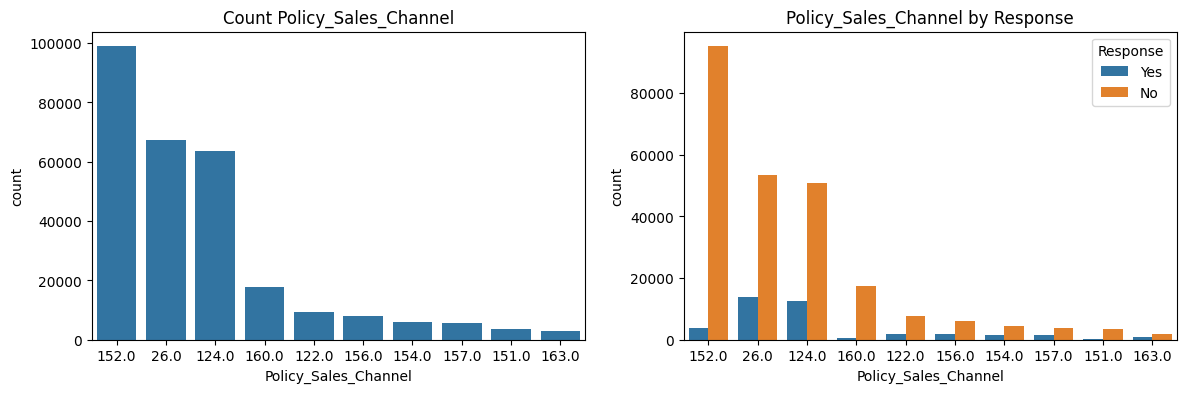

In [ ]:
plot_categorical(df, "Policy_Sales_Channel")

In [ ]:
cross_tabulation(df, "Response", "Policy_Sales_Channel")

Frequency table of Policy_Sales_Channel by Response

Policy_Sales_Channel  1.0   1.0(%)  10.0  10.0(%)  100.0 100.0(%)  101.0  \
Response                                                                   
No                    819  (95.9%)   212  (80.9%)      6  (75.0%)      5   
Yes                    35   (4.1%)    50  (19.1%)      2  (25.0%)      2   

Policy_Sales_Channel 101.0(%)  102.0  102.0(%)  ...  95.0   95.0(%)  96.0  \
Response                                        ...                         
No                    (71.4%)      3  (100.0%)  ...     9  (100.0%)    16   
Yes                   (28.6%)      0    (0.0%)  ...     0    (0.0%)     0   

Policy_Sales_Channel   96.0(%)  97.0  97.0(%)  98.0  98.0(%)  99.0   99.0(%)  
Response                                                                      
No                    (100.0%)    12  (92.3%)    18  (94.7%)     7  (100.0%)  
Yes                     (0.0%)     1   (7.7%)     1   (5.3%)     0    (0.0%)  

[2 rows x 310 co

As for **Region_code** variable, only the first 10 out of 155 channels by frequency are shown, you can immediately notice that after a few of channels there is a drop of observations. More consideration about this will be next.

### Policy Sales Channel and Region_code aggregation

**Region_code** and **Policy_Sales_Channel** are categorical variables with many modes. As we have observed from the graphs where the first 10 most numerous are shown, we can already see a drastic drop in the amount of data available. Given that we must apply OneHotEncoding to these variables to give them to the model, these alone would generate more than 200 features.
To avoid all these features we opt to combine the less frequent methods in the following way:

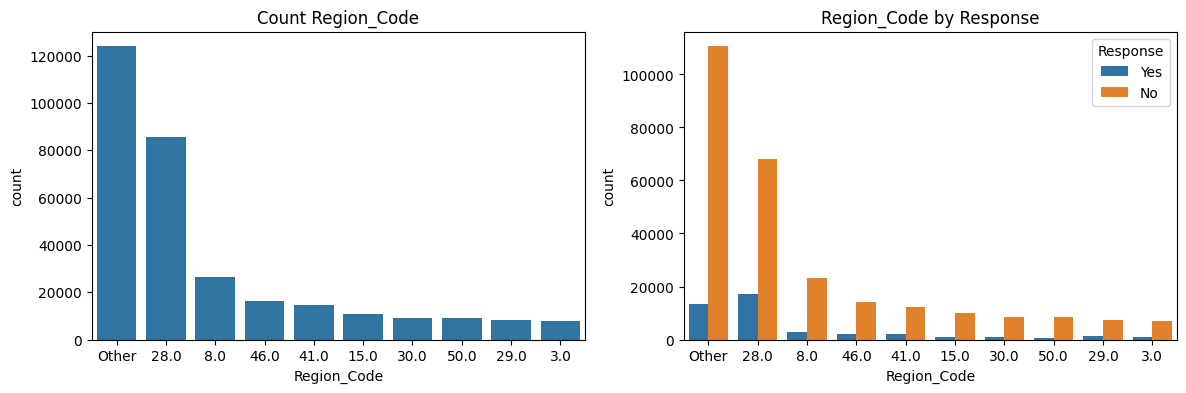

In [ ]:
threshold = 0.025

df["Region_Code"] = aggregate_less_frequent(df, "Region_Code", threshold)

plot_categorical(df, "Region_Code")

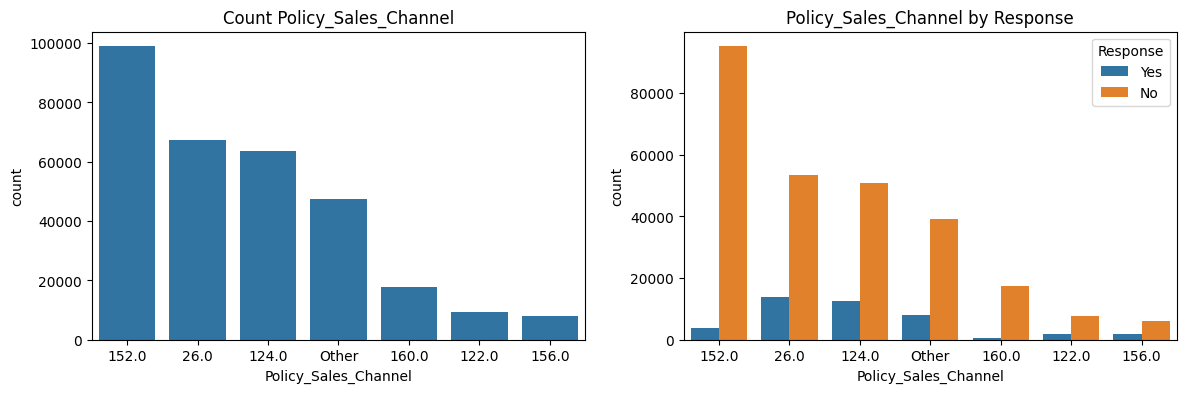

In [ ]:
df["Policy_Sales_Channel"] = aggregate_less_frequent(df, "Policy_Sales_Channel", threshold)

plot_categorical(df, "Policy_Sales_Channel")

### Response

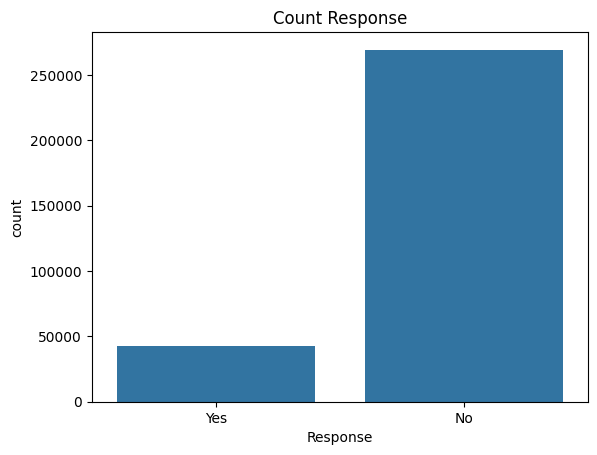

In [ ]:
plt.title("Count Response")
sns.countplot(data=df, x="Response")
plt.show()

In [ ]:
response_percentage_yes = round((Counter(df["Response"])["Yes"])/len(df["Response"]), 5)*100

print(f"Percentage of custermer's postive response: {response_percentage_yes:.4g}%")

Percentage of custermer's postive response: 13.61%


So, 13.61% is the threshold to overcome. We have to try to create a model that can do better than 13.61% (i.e. choosing the people to contact without a particular strategy).

## Correlation/Association

We will calculate the correlation/strength of association of features for both categorical and continuous features by using:
- Pearson's R for continuous-continuous
- Correlation Ratio for categorical-continuous
- Cramer's V for categorical-categorical


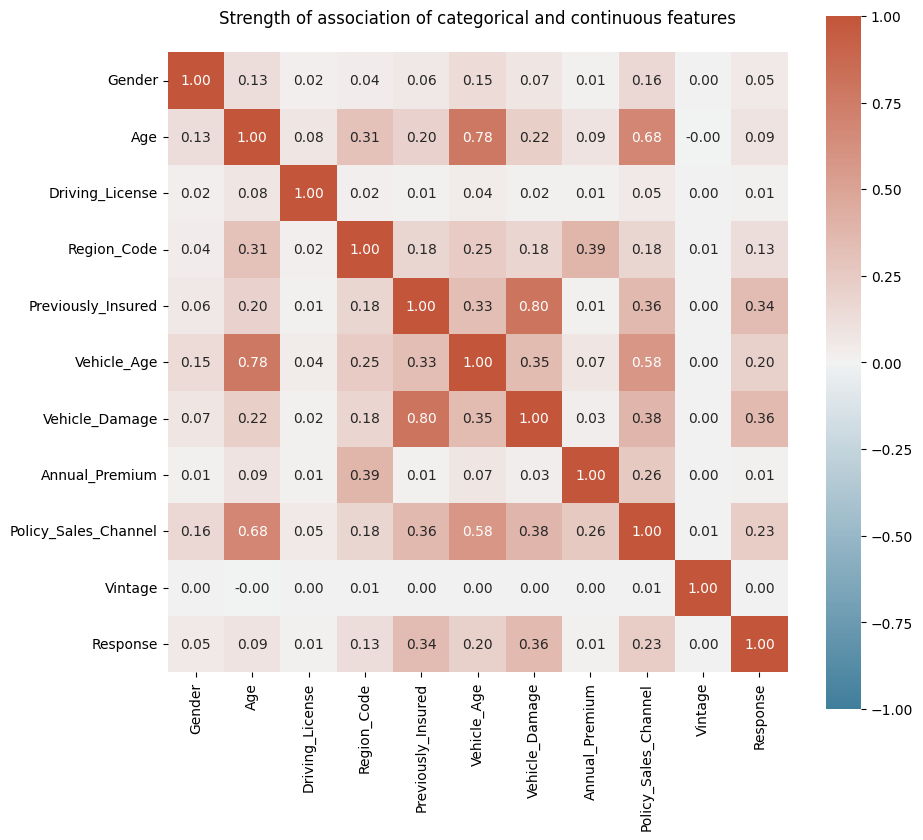

In [ ]:
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

c = nominal.associations(df, figsize=(10,9), cmap=cmap, title="Strength of association of categorical and continuous features\n")

Some pairs of variables are highly correlated. Later we will evaluate the possibility of reducing the size of the dataset through a feature selection.

# Prepocressor

The model requires only numerical values. Let's retransform all the categorical variables to make them suitable for interpretation. We will use **ColumnTransformer** which will be applied according to our needs to all the variables.

In [ ]:
# To make sure we don't make mistakes we manually convert the Response variable

size_mapping_Response = {"Yes":1, "No":0}
df["Response"] = df["Response"].map(size_mapping_Response)

In [ ]:
# Definition of order for ordinal variable
Vehicle_Age_Ord = [["< 1 Year", "1-2 Year", "> 2 Years"]]

preprocessor = ColumnTransformer(
    transformers=[
        # OrdinalEncoder for ordinal variable
        ('ord', OrdinalEncoder(categories=Vehicle_Age_Ord), ["Vehicle_Age"]),

        # OneHotEncoder for nominal variables
        ('nom', OneHotEncoder(), ["Region_Code", "Policy_Sales_Channel"]),

        # OridinalEncoder for binary variables
        ('bin', OrdinalEncoder(), ["Gender", "Driving_License", "Previously_Insured", "Vehicle_Damage"]),

        # Standardization for numerical variables
        ("num", StandardScaler(), ["Age", "Annual_Premium", "Vintage"])
    ])

# Predictive models exploration

We defined the various premises and performed the appropriate changes to the dataset. Now we are going to creat a model to try to best classify the **Response** variable.
We will only focus on logistic regression for this project, but we will analyze different approaches to evaluate the one that best suits our problem, since we are in a case of an unbalanced dataset, as seen in the exploratory part.
To prevent the model from classifying everything in the majority class, we will pay particular attention to the metric we should use (in this case, accuracy and ROC AUC score may not be ideal), because ROC AUC score can be sometimes misleading if there is a class imbalance. When the positive class is very small, ROC AUC can give a false impression of high quality metrics. The model correctly classifies most of the negative instances, and it may miss most of the positives, which is likely more important for the model performance. In this case, it may be more appropriate to look at the precision-recall curve and rely on metrics like precision, recall, or F1-score to evaluate model quality. With a focus on recall because we don't want to lose any potential customers.

We are going to test the following techniques:

1) **Baseline model**: Without setting any parameter.

2) **Class weight**: Is set to “balanced” mode and it uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)).

3) **Oversampling**: It generates new samples of the minority class by picking random samples with replacement.

4) **Undersamplig**: It reduces the number of observations from all classes but the minority class (minority class is the one with the least number of observations).

5) **SMOTENC**: It is an oversampling technique that instead of simply replicating instances of the minority class, it creates new synthetic examples.  
(We use SMOTENC instead of SMOTE because we have both categorical and numerical variables.)


**Note**: We will generate new samples using the last three techniques only on the training data. None of the information in the test data is being used to create new observations. So we avoid data leakage and these results should be generalizable.

## Train and Test subsets

To ensure that our model adapts well to unknown data, we are going to divide our dataset into train and test. The model will be trained only on train set and the ability to generalize on the test set will be analyzed.
We start by dividing features (X) and response (y) and then creating the respective train and test sets.

In [ ]:
X = df.drop("Response", axis=1)
y = df["Response"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)


## Baseline model

### Pipeline

In [ ]:
base_model_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression())
    ]
)

### Model fit

In [ ]:
base_model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ord',
                                                  OrdinalEncoder(categories=[['< '
                                                                              '1 '
                                                                              'Year',
                                                                              '1-2 '
                                                                              'Year',
                                                                              '> '
                                                                              '2 '
                                                                              'Years']]),
                                                  ['Vehicle_Age']),
                                                 ('nom', OneHotEncoder(),
                                                  ['Region_Code',
                                                   'Policy_Sales_Channel']),
                                                 ('bin', OrdinalEncoder(),
                                                  ['Gender', 'Driving_License',
                                                   'Previously_Insured',
                                                   'Vehicle_Damage']),
                                                 ('num', StandardScaler(),
                                                  ['Age', 'Annual_Premium',
                                                   'Vintage'])])),
                ('classifier', LogisticRegression())])

### Metric and Evaluation

In [ ]:
print("Test subsets classification metrics\n")
print(classification_report(y_test, base_model_pipeline.predict(X_test), target_names=["No", "Yes"], digits=3))

Test subsets classification metrics

              precision    recall  f1-score   support

          No      0.864     0.999     0.927     67368
         Yes      0.233     0.001     0.003     10615

    accuracy                          0.863     77983
   macro avg      0.549     0.500     0.465     77983
weighted avg      0.778     0.863     0.801     77983



We obtain an accuracy of 86%, which is not bad at all, but, as previously underlined, this is misleading because when we look at the other metrics of our class of interest "Yes" we notice that:

**Precison**: 23% of the predictions made by the model for class "Yes" are correct. So 77% are false positives.

**Recall**: It results a 0.001%. This means 99.999% of the examples of class "Yes" are incorrectly classified as class "No".

**F1-Score**: The harmonic mean of Precison and Recall indicates a low performance of almost zero for class "Yes".

In short, the model is able to correctly classify only 0.001% of cases, 23% of which is correctly predicted. Therefore it is quite useless for our purpose.

## Weight balance

### Pipeline

In [ ]:
balanced_model_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(class_weight="balanced"))
    ]
)

### Model fit

In [ ]:
balanced_model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ord',
                                                  OrdinalEncoder(categories=[['< '
                                                                              '1 '
                                                                              'Year',
                                                                              '1-2 '
                                                                              'Year',
                                                                              '> '
                                                                              '2 '
                                                                              'Years']]),
                                                  ['Vehicle_Age']),
                                                 ('nom', OneHotEncoder(),
                                                  ['Region_Code',
                                                   'Policy_Sales_Channel']),
                                                 ('bin', OrdinalEncoder(),
                                                  ['Gender', 'Driving_License',
                                                   'Previously_Insured',
                                                   'Vehicle_Damage']),
                                                 ('num', StandardScaler(),
                                                  ['Age', 'Annual_Premium',
                                                   'Vintage'])])),
                ('classifier', LogisticRegression(class_weight='balanced'))])

### Metric and Evaluation

In [ ]:
print(classification_report(y_test, balanced_model_pipeline.predict(X_test), target_names=["No", "Yes"]))

              precision    recall  f1-score   support

          No       0.99      0.63      0.77     67368
         Yes       0.29      0.94      0.44     10615

    accuracy                           0.67     77983
   macro avg       0.64      0.79      0.61     77983
weighted avg       0.89      0.67      0.73     77983



Looking at the metrics, the model fits better than the baseline model.

Let's analyze in detail:

**Precison**: 29% of the predictions made by the model for class "Yes" are correct. So 71% are false positives.

**Recall**: It results in a 94%. This means 6% of the examples of class "Yes" are incorrectly classified as class "No". A clear improvement compared to the baseline model.

**F1-Score**: The harmonic mean of Precison and Recall is 0.44, indicating an overall not so good performance for class "Yes".


## Oversampling

### Resampling and fit

In [ ]:
oversample = RandomOverSampler(sampling_strategy="minority", random_state=0)

# fits the resampler to the input data and then generates a new balanced dataset
X_over, y_over = oversample.fit_resample(X_train, y_train)

Let's look at how oversampling changes our dataset:

In [ ]:
print("Counter of tagert's class:")
print(f"Class No:{Counter(y_train)[0]} | Class Yes:{Counter(y_train)[1]}")
print("---------------------------------------------")
print("Counter of tagert's class after oversampling:")
print(f"Class No:{Counter(y_over)[0]} | Class Yes:{Counter(y_over)[1]}")

Counter of tagert's class:
Class No:202104 | Class Yes:31845
---------------------------------------------
Counter of tagert's class after oversampling:
Class No:202104 | Class Yes:202104


### Pipeline

In [ ]:
over_model_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression())
    ]
)

### Model fit

In [ ]:
over_model_pipeline.fit(X_over, y_over)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ord',
                                                  OrdinalEncoder(categories=[['< '
                                                                              '1 '
                                                                              'Year',
                                                                              '1-2 '
                                                                              'Year',
                                                                              '> '
                                                                              '2 '
                                                                              'Years']]),
                                                  ['Vehicle_Age']),
                                                 ('nom', OneHotEncoder(),
                                                  ['Region_Code',
                                                   'Policy_Sales_Channel']),
                                                 ('bin', OrdinalEncoder(),
                                                  ['Gender', 'Driving_License',
                                                   'Previously_Insured',
                                                   'Vehicle_Damage']),
                                                 ('num', StandardScaler(),
                                                  ['Age', 'Annual_Premium',
                                                   'Vintage'])])),
                ('classifier', LogisticRegression())])

### Metric and Evaluation

In [ ]:
print(classification_report(y_test, over_model_pipeline.predict(X_test), target_names=["No", "Yes"]))

              precision    recall  f1-score   support

          No       0.98      0.64      0.77     67368
         Yes       0.29      0.94      0.44     10615

    accuracy                           0.68     77983
   macro avg       0.64      0.79      0.61     77983
weighted avg       0.89      0.68      0.73     77983



We do not notice significant differences at the metrics level from the previous model.

## Undersampling

### Resampling and fit

In [ ]:
undersample = RandomUnderSampler(random_state=0)

# fits the resampler to the input data and then generates a new balanced dataset
X_under, y_under = undersample.fit_resample(X_train, y_train)

Let's look at how undersampling changes our dataset:

In [ ]:
print("Counter of tagert's class:")
print(f"Class No:{Counter(y_train)[0]} | Class Yes:{Counter(y_train)[1]}")
print("---------------------------------------------")
print("Counter of tagert's class after undersampling:")
print(f"Class No:{Counter(y_under)[0]} | Class Yes:{Counter(y_under)[1]}")

Counter of tagert's class:
Class No:202104 | Class Yes:31845
---------------------------------------------
Counter of tagert's class after undersampling:
Class No:31845 | Class Yes:31845


### Pipeline

In [ ]:
under_model_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression())
    ]
)

### Model fit

In [ ]:
under_model_pipeline.fit(X_under, y_under)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ord',
                                                  OrdinalEncoder(categories=[['< '
                                                                              '1 '
                                                                              'Year',
                                                                              '1-2 '
                                                                              'Year',
                                                                              '> '
                                                                              '2 '
                                                                              'Years']]),
                                                  ['Vehicle_Age']),
                                                 ('nom', OneHotEncoder(),
                                                  ['Region_Code',
                                                   'Policy_Sales_Channel']),
                                                 ('bin', OrdinalEncoder(),
                                                  ['Gender', 'Driving_License',
                                                   'Previously_Insured',
                                                   'Vehicle_Damage']),
                                                 ('num', StandardScaler(),
                                                  ['Age', 'Annual_Premium',
                                                   'Vintage'])])),
                ('classifier', LogisticRegression())])

### Metric and Evaluation

In [ ]:
print(classification_report(y_test, under_model_pipeline.predict(X_test), target_names=["No", "Yes"]))

              precision    recall  f1-score   support

          No       0.98      0.63      0.77     67368
         Yes       0.29      0.94      0.44     10615

    accuracy                           0.68     77983
   macro avg       0.64      0.79      0.61     77983
weighted avg       0.89      0.68      0.73     77983



We do not notice significant differences at the metrics from the model fitted with over sampling and class weight balance.

## SMOTENC

### Resampling and fit

In [ ]:
from imblearn.over_sampling import SMOTENC

# list of categorical variables required by SMOTENC
categorical_variables = X_train.select_dtypes(include="object").columns
categotical_indices = [X_train.columns.get_loc(col) for col in categorical_variables]

SMOTENC = SMOTENC(sampling_strategy="minority", random_state=0, categorical_features=categotical_indices)

X_res, y_res = SMOTENC.fit_resample(X_train, y_train)

Let's look at how SMOTENC changes our dataset:


In [ ]:
print("Counter of tagert's class:")
print(f"Class No:{Counter(y_train)[0]} | Class Yes:{Counter(y_train)[1]}")
print("----------------------------------------")
print("Counter of tagert's class after smotenc:")
print(f"Class No:{Counter(y_res)[0]} | Class Yes:{Counter(y_res)[1]}")

Counter of tagert's class:
Class No:202104 | Class Yes:31845
----------------------------------------
Counter of tagert's class after smotenc:
Class No:202104 | Class Yes:202104


### Pipeline

In [ ]:
smotenc_model_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression())
    ]
)

### Model fit

In [ ]:
smotenc_model_pipeline.fit(X_res, y_res)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ord',
                                                  OrdinalEncoder(categories=[['< '
                                                                              '1 '
                                                                              'Year',
                                                                              '1-2 '
                                                                              'Year',
                                                                              '> '
                                                                              '2 '
                                                                              'Years']]),
                                                  ['Vehicle_Age']),
                                                 ('nom', OneHotEncoder(),
                                                  ['Region_Code',
                                                   'Policy_Sales_Channel']),
                                                 ('bin', OrdinalEncoder(),
                                                  ['Gender', 'Driving_License',
                                                   'Previously_Insured',
                                                   'Vehicle_Damage']),
                                                 ('num', StandardScaler(),
                                                  ['Age', 'Annual_Premium',
                                                   'Vintage'])])),
                ('classifier', LogisticRegression())])

### Metric and Evaluation

In [ ]:
print(classification_report(y_test, smotenc_model_pipeline.predict(X_test), target_names=["No", "Yes"]))

              precision    recall  f1-score   support

          No       0.97      0.68      0.80     67368
         Yes       0.30      0.85      0.44     10615

    accuracy                           0.70     77983
   macro avg       0.63      0.76      0.62     77983
weighted avg       0.87      0.70      0.75     77983



we notice a slight improvement in precision, but a worsening of recall for the class Yes, from the model fitted with under or oversampling and class weight balance.

# Best model

By applying resampling techniques, we do not notice significant differences in the metrics. The balancing techniques are not adding significant value in our dataset, which means that we don't have enough data to adequately estimate the model parameters.

For a more in-depth analysis, we will use **Elastic Net** and try tuning the hyperparameters to improve the overall model performance. **Elastic Net** is a regularization technique that combines Lasso and Ridge, and can manage multicollinearity, do feature selection, reduce the risk of overfitting and underfitting to find an optimal balance between model complexity and predictive capacity.


## Hyperparameter Tuning

These are the hyperparameters of the logistic regression that we want to optimize:

In [ ]:
param_grid  = { "classifier":[LogisticRegression(solver="saga", class_weight="balanced")],
                "classifier__C":[0.001, 0.01, 0.1, 1, 10],
                "classifier__penalty":["elasticnet"],
                "classifier__l1_ratio":[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7 ,0.8, 0.9, 1]
              }

We will use **RandomizedSearchCV** to try finding an optimal hyperparameters value.

In [ ]:
rs = RandomizedSearchCV(
    estimator=balanced_model_pipeline,
    param_distributions=param_grid,
    scoring="recall", # reference metric
    cv=5,
    random_state=0,
    n_jobs=-1
)

best_model = rs.fit(X_train, y_train)

In [ ]:
print(f"Optimized model and its parameters:\n\n", best_model.best_params_)

Optimized model and its parameters:

 {'classifier__penalty': 'elasticnet', 'classifier__l1_ratio': 0.2, 'classifier__C': 0.001, 'classifier': LogisticRegression(C=0.001, class_weight='balanced', l1_ratio=0.2,
                   penalty='elasticnet', solver='saga')}


Now that we have the model with the hyperparameters optimized, let's see how the various features influence the output:

## Features importance

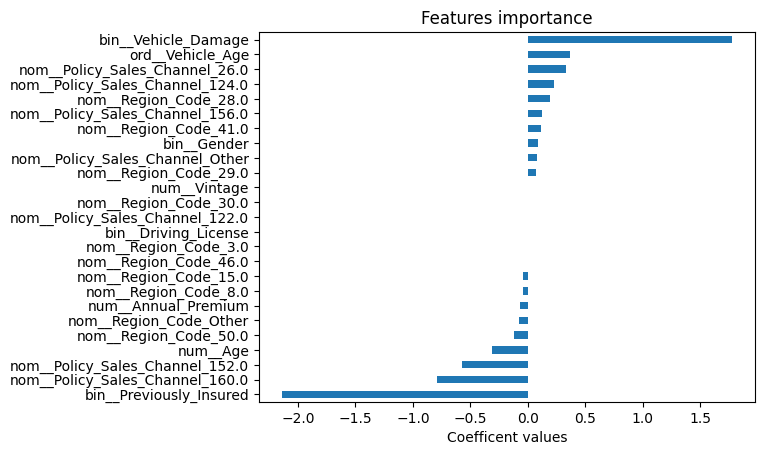

In [ ]:
feature_names = np.array(best_model.best_estimator_["preprocessor"].get_feature_names_out())
importances = np.array(best_model.best_estimator_["classifier"].coef_[0])
pd.Series(importances, index=feature_names).sort_values().plot(kind="barh")
plt.title("Features importance")
plt.xlabel("Coefficent values")
plt.show()

If the sign of the coefficient is positive, there is an increase in the probability that the observation belongs to the class "Yes". On the contrary, if the sign of the coefficient is negative, there is an increase in the probability that the observation belongs to the class "No".

Furthermore, in addition to the sign, the absolute value of the coefficient must also be taken into account; the larger the value, the more the variable has a strong effect on the output, while small values ​​have a weaker effect on the output.

Now let's analyze how the various features influence the model predictions:

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(best_model.best_estimator_["preprocessor"].transform(X_train),
                                                   feature_names=feature_names,
                                                   mode="classification")
# to choose random
# i = np.random.randint(0, best_model.best_estimator_["preprocessor"].transform(X_train).shape[0])

# to make our consideration will focus only on the row in postition 8
exp = explainer.explain_instance(best_model.best_estimator_["preprocessor"].transform(X_train)[8],
                                 best_model.best_estimator_["classifier"].predict_proba,
                                 num_features = 10)


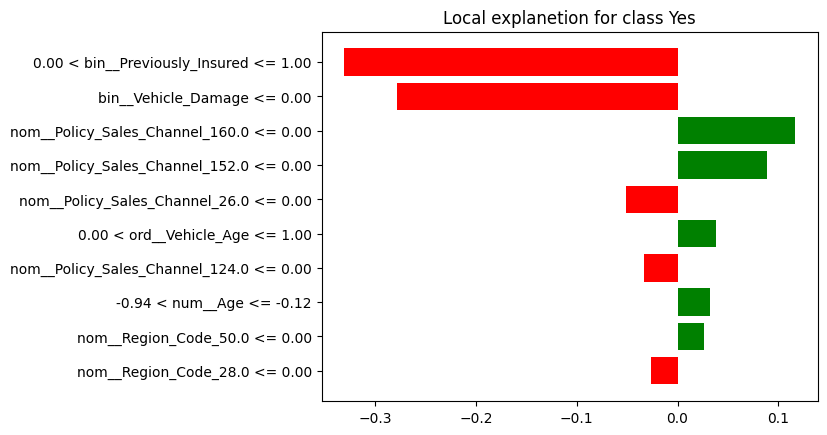

In [ ]:
exp.as_pyplot_figure()
plt.title("Local explanetion for class Yes")
plt.show()

In [ ]:
record_index = 8
predicted_probabilities = best_model.predict_proba(X_test.iloc[[record_index]])
predicted_class = best_model.predict(X_test.iloc[[record_index]])
predicted_class = np.where(predicted_class==0, "No", "Yes")

print(f"Model predicted probabilities for record {record_index} are:")
print(f"Belonging Class No: {predicted_probabilities[0][0]*100:.3g}% | Belonging Class Yes: {predicted_probabilities[0][1]*100:.2g}%")
print(f"The predicted class is: {predicted_class}")

Model predicted probabilities for record 8 are:
Belonging Class No: 97.9% | Belonging Class Yes: 2.1%
The predicted class is: ['No']


In conclusion, the model classifies it as belonging to the class "No", because, as noticed previously, the two variables that have the greatest influence are **Previously_Insured**=1 (positive) and **Vehicle_Damage**=0 (negative).

So a customer who already has the vehicle insured and which vehicle has no damage, will most likely not be interested in the offer.

## Metric and Final evaluation

In [ ]:
print(classification_report(y_test, best_model.predict(X_test), target_names=["No", "Yes"]))

              precision    recall  f1-score   support

          No       0.99      0.62      0.76     67368
         Yes       0.28      0.95      0.43     10615

    accuracy                           0.67     77983
   macro avg       0.63      0.78      0.60     77983
weighted avg       0.89      0.67      0.72     77983



The dataset may contain too much noise, so hyperparameter tuning does not have much impact.

Now we will try to change the threshold (default is 0.5) to improve the model performance.

Now, since our goal is predicting as much as we can class "Yes", we will set a lower threshold, and this will lead us to classify more instances as class "Yes", potentially increasing recall but decreasing precision.

Conversely, a higher threshold will classify fewer instances as class "Yes", potentially increasing precision but decreasing recall.

Let's try for example a thershold of 0.35:

In [ ]:
y_proba_test = best_model.predict_proba(X_test)

y_pred_test = np.where(y_proba_test[:, 1] > 0.30, 1, 0)

print(classification_report(y_test, y_pred_test, target_names=["No", "Yes"]))

              precision    recall  f1-score   support

          No       1.00      0.56      0.71     67368
         Yes       0.26      0.98      0.41     10615

    accuracy                           0.62     77983
   macro avg       0.63      0.77      0.56     77983
weighted avg       0.90      0.62      0.67     77983



Even by trying varius thersholds we do not notice significant improvement. There is no good trade off between precision and recall, so our final model will be the one with optimized hyperparameters and with defeault thershold.

Let's look at Precision-Recall graph and confusion matrix of the model:

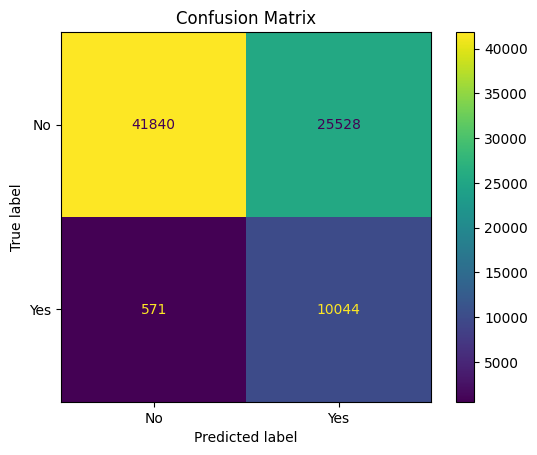

In [ ]:
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, display_labels = ["No", "Yes"], values_format=".5g")
plt.title("Confusion Matrix")
plt.show()

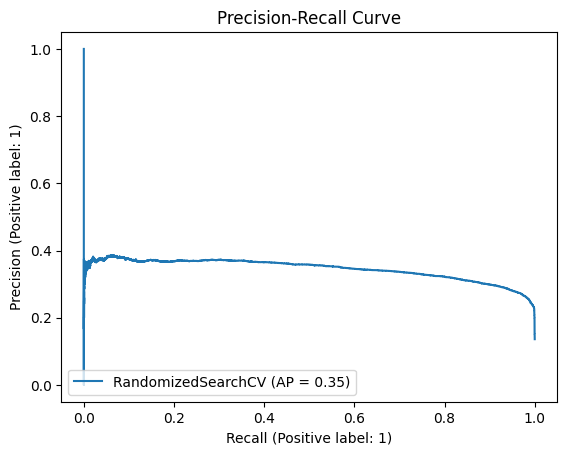

In [ ]:
PrecisionRecallDisplay.from_estimator(best_model, X_test, y_test)
plt.title("Precision-Recall Curve")
plt.show()

An AP of 35% indicates that, on average, the model has an accuracy of 34% when recall ranges from 0% to 100%. Thus, in this context, 35% is not bad considering a good performance is difficult to achieve.

In conclusion, after having carried out cleaning, feature engineering and hyperparameter optimization, we obtain a model that correctly identifies almost 30% of the potential interested customers.

Considering that without a particular strategy around 13% of customers gave an affirmative response to the offer, we now have more than double the previous probability of identifying interested potential customers.